In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ciciot2023-10sample/ciciot2023_10percent_sample.csv


In [2]:
import pandas as pd
# Specify the file path
file_path = '/kaggle/input/ciciot2023-10sample/ciciot2023_10percent_sample.csv'
dataset = pd.read_csv(file_path)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Basic exploration
print("Shape of the dataset:", dataset.shape)
print("\nData Types:")
print(dataset.dtypes)
print("\nNull Values:")
print(dataset.isnull().sum())
print("\nMemory Usage:")
print(dataset.memory_usage(deep=True))

Shape of the dataset: (3670106, 40)

Data Types:
Header_Length      float64
Protocol Type      float64
Time_To_Live       float64
Rate               float64
fin_flag_number    float64
syn_flag_number    float64
rst_flag_number    float64
psh_flag_number    float64
ack_flag_number    float64
ece_flag_number    float64
cwr_flag_number    float64
ack_count          float64
syn_count          float64
fin_count          float64
rst_count          float64
HTTP               float64
HTTPS              float64
DNS                float64
Telnet             float64
SMTP               float64
SSH                float64
IRC                float64
TCP                float64
UDP                float64
DHCP               float64
ARP                float64
ICMP               float64
IGMP               float64
IPv                float64
LLC                float64
Tot sum            float64
Min                float64
Max                float64
AVG                float64
Std                float64
Tot si

In [4]:
# Label distribution (categorical column)
print("\nLabel Distribution:")
print(dataset['label'].value_counts())


Label Distribution:
label
DDoS-ICMP_Flood            693351
DDoS-TCP_Flood             449753
DDoS-RSTFINFLOOD           404525
DDoS-PSHACK_FLOOD          382698
DDoS-SynonymousIP_Flood    359813
DoS-UDP_Flood              307296
DoS-TCP_Flood              267141
DoS-SYN_Flood              202881
Bening_Final               109813
Mirai-greeth_flood          99178
Mirai-udpplain              89052
Mirai-greip_flood           75160
DDoS-ICMP_Fragmentation     45247
VulnerabilityScan           37334
MITM-ArpSpoofing            30755
DDoS-UDP_Fragmentation      26419
DDoS-ACK_Fragmentation      26228
DNS_Spoofing                17890
Recon-HostDiscovery         13438
Recon-OSScan                 9826
Recon-PortScan               8228
DoS-HTTP_Flood               7186
DDoS-HTTP_Flood              2879
DictionaryBruteForce         1306
BrowserHijacking              586
CommandInjection              541
SqlInjection                  524
XSS                           385
Backdoor_Malware     

In [3]:
       !pip install --upgrade scikit-learn==1.2.2
!pip install imbalanced-learn==0.10.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 5.4 MB/s eta 0:00:0000:01
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
import collections
import os

# ========= Step 0: Clean NaN and infinite values =========
print("Checking for missing values...")
dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
missing_total = dataset.isnull().sum().sum()
print(f"Missing values: {missing_total}")
dataset.dropna(inplace=True)

# ========= Step 1: Drop low-variance columns =========
print("Dropping low-variance columns...")
low_var_cols = [col for col in dataset.columns if dataset[col].nunique() <= 1]
dataset.drop(columns=low_var_cols, inplace=True)

# ========= Step 2: Encode labels =========
print("Encoding labels...")
le = LabelEncoder()
dataset['label'] = le.fit_transform(dataset['label'])

# ========= Step 3: Feature-label split =========
X = dataset.drop(columns=['label'])
y = dataset['label']

# ========= Step 4: Normalize features =========
print("Scaling features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_df = pd.DataFrame(X_scaled)

# ========= Step 5: Drop highly correlated features (r > 0.95) =========
print("Removing highly correlated features...")
corr_matrix = X_df.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper_tri.columns if any(upper_tri[col] > 0.95)]
X_selected = X_df.drop(columns=to_drop).values
print(f"Features remaining: {X_selected.shape[1]}")

# ========= Step 6: Train-test split (80/20) =========
X_temp, X_test, y_temp, y_test = train_test_split(
    X_selected, y, test_size=0.2, stratify=y, random_state=42
)

# ========= Step 7: Labeled-Unlabeled split (20% labeled) =========
X_lab, X_unlab, y_lab, y_unlab = train_test_split(
    X_temp, y_temp, test_size=0.8, stratify=y_temp, random_state=42
)


Checking for missing values...
Missing values: 0
Dropping low-variance columns...
Encoding labels...
Scaling features...
Removing highly correlated features...


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


Features remaining: 31


In [5]:
# ========= Step 8: SMOTE Balancing =========
def apply_adaptive_smote(X, y, random_state=42):
    class_counts = collections.Counter(y)
    sampling_strategy = {}
    
    for class_id, count in class_counts.items():
        if count < 500:
            target = 1000
        elif count < 3000:
            target = min(3000, count * 3)
        elif count < 30000:
            target = min(15000, count * 2)
        else:
            continue  # skip large classes
        
        # Ensure requested target is strictly >= current count
        if target > count:
            sampling_strategy[class_id] = target

    print(f"Adaptive SMOTE strategy: {sampling_strategy}")
    
    if not sampling_strategy:
        print("No classes require SMOTE oversampling.")
        return X, y

    smote = SMOTE(sampling_strategy=sampling_strategy, random_state=random_state, k_neighbors=3)
    return smote.fit_resample(X, y)


import collections
from imblearn.over_sampling import BorderlineSMOTE, SMOTE

def apply_borderline_smote_limited(X, y, random_state=42):
    class_counts = collections.Counter(y)
    avg_target = 5000
    k_neighbors = 3

    borderline_classes = {}
    for cls, count in class_counts.items():
        if count < avg_target and count > k_neighbors:
            borderline_classes[cls] = avg_target

    print(f"Borderline SMOTE strategy: {borderline_classes}")

    X_res, y_res = X, y
    failed_classes = []

    # Try BorderlineSMOTE
    if borderline_classes:
        try:
            smote = BorderlineSMOTE(sampling_strategy=borderline_classes, random_state=random_state, k_neighbors=k_neighbors)
            X_res, y_res = smote.fit_resample(X_res, y_res)
        except ValueError as e:
            print(f"BorderlineSMOTE failed: {e}")

    # Check which classes still didn’t reach the target
    new_class_counts = collections.Counter(y_res)
    for cls, target in borderline_classes.items():
        if new_class_counts[cls] < target:
            failed_classes.append(cls)

    fallback_classes = {cls: avg_target for cls in failed_classes}
    print(f"Fallback to regular SMOTE for: {fallback_classes}")

    # Fallback SMOTE for failed classes
    if fallback_classes:
        try:
            smote = SMOTE(sampling_strategy=fallback_classes, random_state=random_state, k_neighbors=min(2, k_neighbors))
            X_res, y_res = smote.fit_resample(X_res, y_res)
        except ValueError as e:
            print(f"Fallback SMOTE failed: {e}")

    return X_res, y_res




print(f"Before SMOTE (Supervised): {collections.Counter(y_lab)}")
print(f"============================")
X_lab_supervised, y_lab_supervised = apply_adaptive_smote(X_lab, y_lab)
print(f"============================")
print(f"After Adaptive SMOTE: {collections.Counter(y_lab_supervised)}")
print(f"============================")
X_lab_mean_teacher, y_lab_mean_teacher = apply_borderline_smote_limited(X_lab, y_lab)
print(f"After Borderline SMOTE: {collections.Counter(y_lab_mean_teacher)}")

# ========= Step 9: Class Weights for supervised =========
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_lab_supervised), y=y_lab_supervised)
class_weight_dict = dict(zip(np.unique(y_lab_supervised), class_weights))


Before SMOTE (Supervised): Counter({6: 110936, 11: 71960, 9: 64724, 8: 61231, 10: 57570, 18: 49167, 17: 42743, 16: 32461, 1: 17570, 20: 15868, 22: 14248, 21: 12026, 7: 7240, 29: 5973, 19: 4921, 12: 4227, 4: 4196, 13: 2862, 23: 2150, 24: 1572, 26: 1316, 15: 1150, 5: 461, 14: 209, 2: 94, 3: 87, 27: 84, 30: 62, 0: 52, 25: 36, 28: 20})
Adaptive SMOTE strategy: {19: 9842, 22: 15000, 12: 8454, 26: 3000, 7: 14480, 13: 3000, 21: 15000, 29: 11946, 23: 3000, 4: 8392, 24: 3000, 14: 1000, 15: 3000, 30: 1000, 5: 1000, 2: 1000, 25: 1000, 0: 1000, 27: 1000, 3: 1000, 28: 1000}
After Adaptive SMOTE: Counter({6: 110936, 11: 71960, 9: 64724, 8: 61231, 10: 57570, 18: 49167, 17: 42743, 16: 32461, 1: 17570, 20: 15868, 22: 15000, 21: 15000, 7: 14480, 29: 11946, 19: 9842, 12: 8454, 4: 8392, 26: 3000, 13: 3000, 23: 3000, 24: 3000, 15: 3000, 14: 1000, 30: 1000, 5: 1000, 2: 1000, 25: 1000, 0: 1000, 27: 1000, 3: 1000, 28: 1000})
Borderline SMOTE strategy: {19: 5000, 12: 5000, 26: 5000, 13: 5000, 23: 5000, 4: 5000

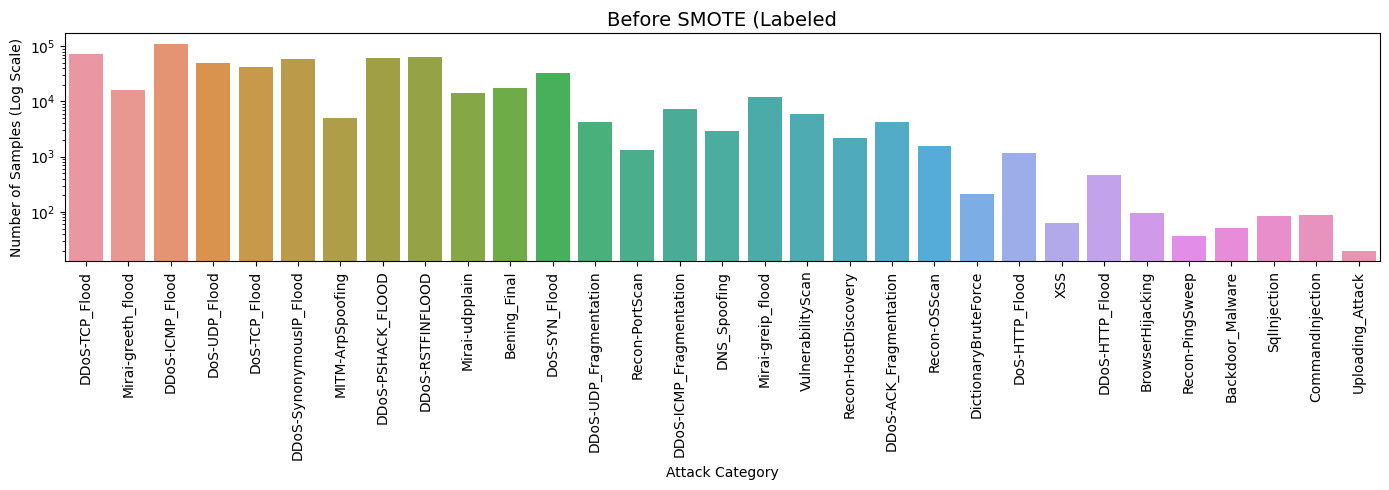

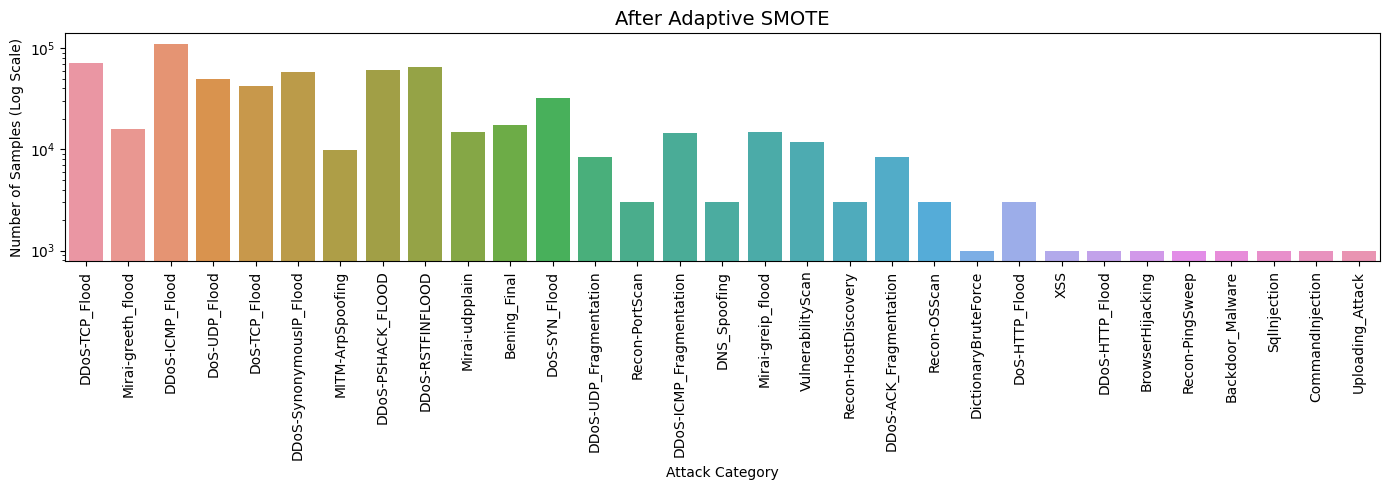

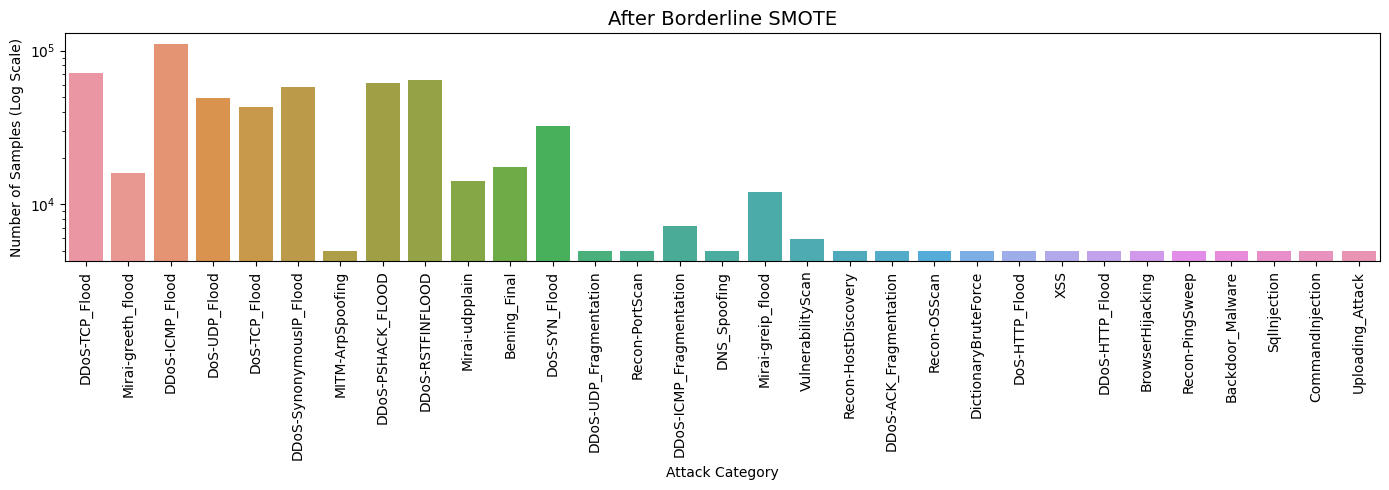

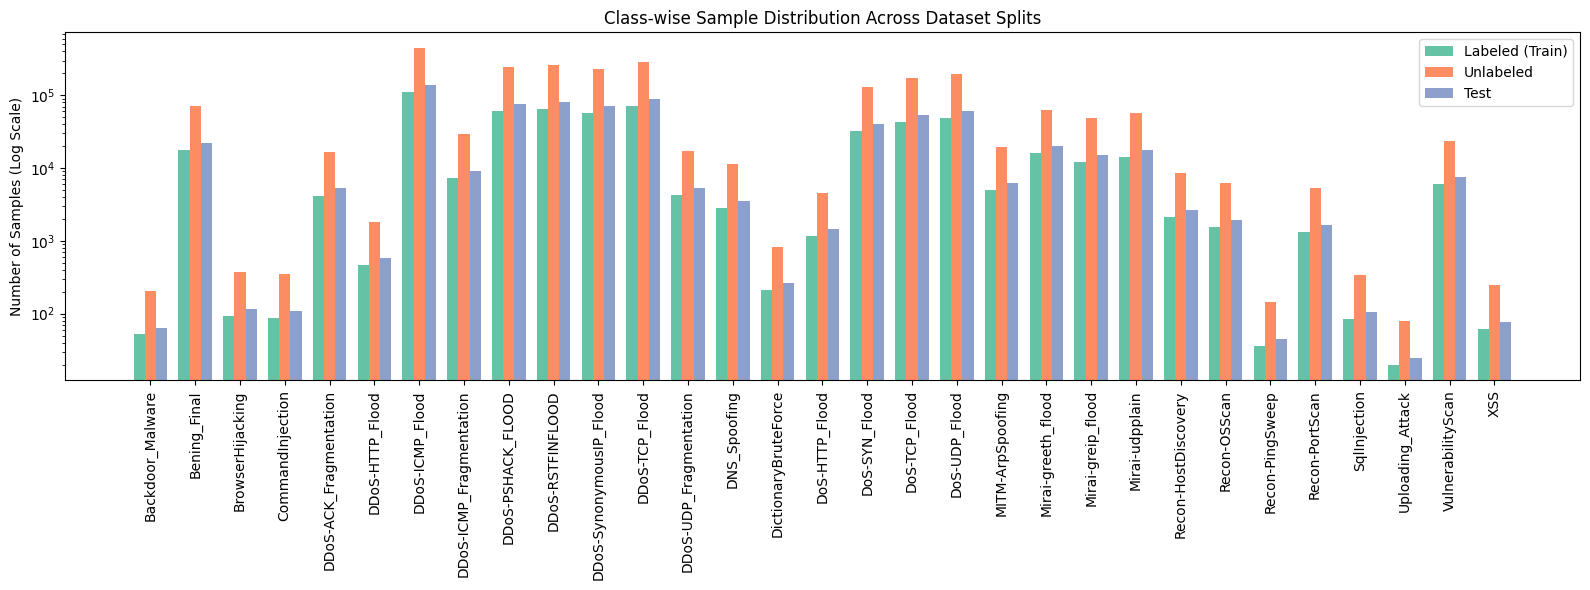

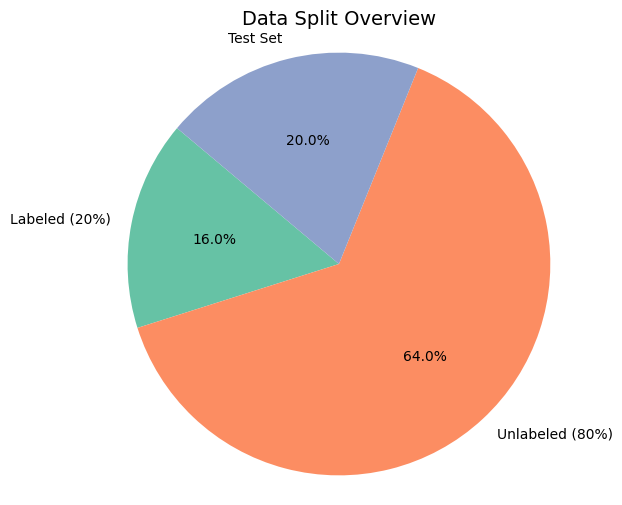

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import collections

# Ensure reverse mapping for all plots
int_to_attack = dict(zip(le.transform(le.classes_), le.classes_))

# Generic Distribution Plotter
def plot_distribution(title, labels, label_encoder):
    counts = collections.Counter(labels)
    classes = list(counts.keys())
    freqs = list(counts.values())
    class_names = [label_encoder.inverse_transform([c])[0] for c in classes]

    plt.figure(figsize=(14, 5))
    sns.barplot(x=np.array(class_names), y=freqs, log=True)
    plt.title(title, fontsize=14)
    plt.ylabel("Number of Samples (Log Scale)")
    plt.xlabel("Attack Category")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

import collections
import matplotlib.pyplot as plt

def plot_classwise_split_bar(y_lab, y_unlab, y_test, label_encoder):
    # Count occurrences in each split
    lab_counts = collections.Counter(y_lab)
    unlab_counts = collections.Counter(y_unlab)
    test_counts = collections.Counter(y_test)

    # Get union of all class labels
    all_classes = sorted(set(lab_counts.keys()) | set(unlab_counts.keys()) | set(test_counts.keys()))

    # Prepare data for plotting
    class_names = [label_encoder.inverse_transform([cls])[0] for cls in all_classes]
    lab_freqs = [lab_counts.get(cls, 0) for cls in all_classes]
    unlab_freqs = [unlab_counts.get(cls, 0) for cls in all_classes]
    test_freqs = [test_counts.get(cls, 0) for cls in all_classes]

    x = range(len(all_classes))
    bar_width = 0.25

    # Plot
    plt.figure(figsize=(16, 6))
    plt.bar([p - bar_width for p in x], lab_freqs, width=bar_width, label='Labeled (Train)', color='#66c2a5')
    plt.bar(x, unlab_freqs, width=bar_width, label='Unlabeled', color='#fc8d62')
    plt.bar([p + bar_width for p in x], test_freqs, width=bar_width, label='Test', color='#8da0cb')

    plt.yscale('log')  # Set y-axis to logarithmic scale
    plt.xticks(x, class_names, rotation=90)
    plt.ylabel("Number of Samples (Log Scale)")
    plt.title("Class-wise Sample Distribution Across Dataset Splits")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Pie Chart for Labeled, Unlabeled, and Test Split
def plot_split_pie(lab_count, unlab_count, test_count):
    sizes = [lab_count, unlab_count, test_count]
    labels = ['Labeled (20%)', 'Unlabeled (80%)', 'Test Set']
    colors = ['#66c2a5', '#fc8d62', '#8da0cb']

    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
    plt.axis('equal')
    plt.title("Data Split Overview", fontsize=14)
    plt.show()

# plot everything
plot_distribution("Before SMOTE (Labeled", y_lab, label_encoder=le)
plot_distribution("After Adaptive SMOTE", y_lab_supervised, label_encoder=le)
plot_distribution("After Borderline SMOTE", y_lab_mean_teacher, label_encoder=le)
plot_classwise_split_bar(y_lab, y_unlab, y_test, label_encoder=le)

# pie chart plot
plot_split_pie(len(X_lab), len(X_unlab), len(X_test))


# Mean Teacher

[Epoch 1/50] Sup Loss: 686.462, Cons Loss: nan | Student Acc: 0.8284 | Teacher Acc: 0.8290
[Epoch 2/50] Sup Loss: 510.473, Cons Loss: 0.078 | Student Acc: 0.8329 | Teacher Acc: 0.8331
[Epoch 3/50] Sup Loss: 481.635, Cons Loss: 0.085 | Student Acc: 0.8361 | Teacher Acc: 0.8358
[Epoch 4/50] Sup Loss: 464.179, Cons Loss: 0.084 | Student Acc: 0.8348 | Teacher Acc: 0.8385
[Epoch 5/50] Sup Loss: 454.161, Cons Loss: 0.089 | Student Acc: 0.8406 | Teacher Acc: 0.8405
[Epoch 6/50] Sup Loss: 447.725, Cons Loss: 0.084 | Student Acc: 0.8535 | Teacher Acc: 0.8490
[Epoch 7/50] Sup Loss: 435.744, Cons Loss: 0.092 | Student Acc: 0.8571 | Teacher Acc: 0.8590
[Epoch 8/50] Sup Loss: 420.438, Cons Loss: 0.194 | Student Acc: 0.8601 | Teacher Acc: 0.8598
[Epoch 9/50] Sup Loss: 409.890, Cons Loss: 0.192 | Student Acc: 0.8601 | Teacher Acc: 0.8602
[Epoch 10/50] Sup Loss: 403.757, Cons Loss: 0.178 | Student Acc: 0.8600 | Teacher Acc: 0.8609
[Epoch 11/50] Sup Loss: 400.618, Cons Loss: 0.166 | Student Acc: 0.8608

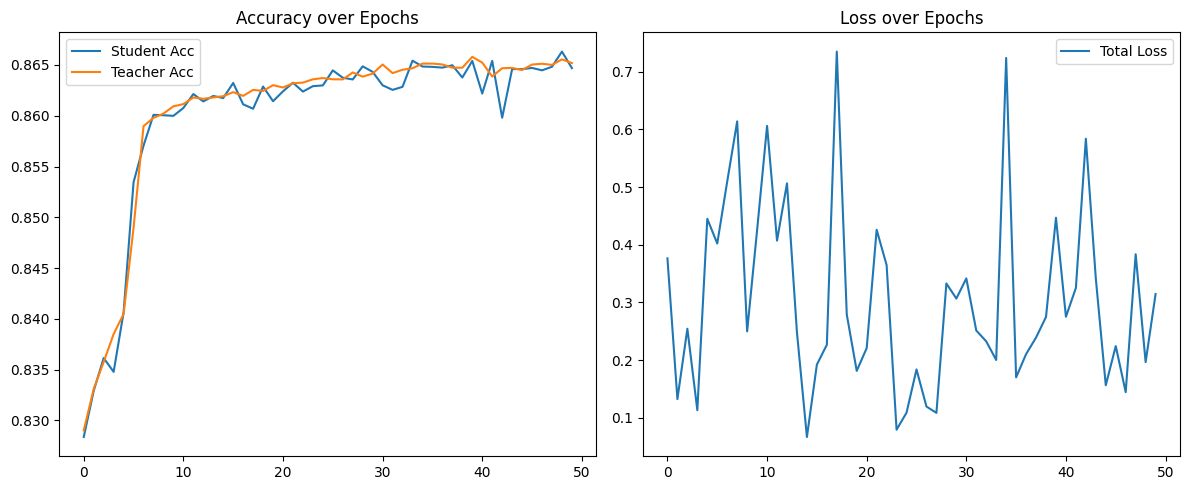

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# ================== CONFIG ==================
num_classes = len(np.unique(y_lab_mean_teacher))
input_dim = X_lab_mean_teacher.shape[1]
epochs = 50
batch_size = 512
ema_decay = 0.99
lambda_consistency = 0.5
confidence_threshold = 0.8
patience = 10

# ================== MODEL DEFINITIONS ==================
def build_mlp_model(input_dim, num_classes):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

student_model = build_mlp_model(input_dim, num_classes)
teacher_model = build_mlp_model(input_dim, num_classes)
teacher_model.set_weights(student_model.get_weights())  # sync initial weights

# Optimizer and loss
optimizer = optimizers.Adam(learning_rate=1e-3)
loss_fn = losses.SparseCategoricalCrossentropy()

# ================== TRAINING LOOP ==================
@tf.function
def train_step(x_labeled, y_labeled, x_unlabeled):
    with tf.GradientTape() as tape:
        # Student forward pass
        logits_labeled = student_model(x_labeled, training=True)
        supervised_loss = loss_fn(y_labeled, logits_labeled)

        # Unlabeled predictions
        student_preds = student_model(x_unlabeled, training=True)
        teacher_preds = teacher_model(x_unlabeled, training=False)

        # Consistency loss (only confident pseudo-labels)
        teacher_conf = tf.reduce_max(teacher_preds, axis=1)
        mask = tf.where(teacher_conf > confidence_threshold)
        filtered_student = tf.gather(student_preds, mask[:, 0])
        filtered_teacher = tf.gather(teacher_preds, mask[:, 0])

        consistency_loss = tf.reduce_mean(tf.square(filtered_student - filtered_teacher))
        total_loss = supervised_loss + lambda_consistency * consistency_loss

    grads = tape.gradient(total_loss, student_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, student_model.trainable_variables))
    return supervised_loss, consistency_loss, total_loss

def update_teacher_weights(student_model, teacher_model, ema_decay):
    student_weights = student_model.get_weights()
    teacher_weights = teacher_model.get_weights()
    new_teacher_weights = [
        ema_decay * tw + (1 - ema_decay) * sw
        for sw, tw in zip(student_weights, teacher_weights)
    ]
    teacher_model.set_weights(new_teacher_weights)

# ================== TRAIN ==================
X_lab_tf = tf.convert_to_tensor(X_lab_mean_teacher, dtype=tf.float32)
y_lab_tf = tf.convert_to_tensor(y_lab_mean_teacher, dtype=tf.int32)
X_unlab_tf = tf.convert_to_tensor(X_unlab, dtype=tf.float32)
X_test_tf = tf.convert_to_tensor(X_test, dtype=tf.float32)

train_accs, test_accs, losses_all = [], [], []

best_acc = 0
wait = 0

for epoch in range(epochs):
    idxs = np.random.permutation(len(X_lab_mean_teacher))
    num_batches = int(np.ceil(len(idxs) / batch_size))
    
    epoch_sup_loss, epoch_cons_loss = 0, 0

    for i in range(num_batches):
        batch_idx = idxs[i*batch_size:(i+1)*batch_size]
        x_batch = tf.gather(X_lab_tf, batch_idx)
        y_batch = tf.gather(y_lab_tf, batch_idx)

        unlab_batch_idx = np.random.choice(len(X_unlab_tf), size=len(batch_idx), replace=False)
        x_unlab_batch = tf.gather(X_unlab_tf, unlab_batch_idx)

        sup_loss, cons_loss, total_loss = train_step(x_batch, y_batch, x_unlab_batch)
        epoch_sup_loss += sup_loss.numpy()
        epoch_cons_loss += cons_loss.numpy()

        update_teacher_weights(student_model, teacher_model, ema_decay)

    # Evaluation
    y_pred_student = np.argmax(student_model.predict(X_test_tf, verbose=0), axis=1)
    y_pred_teacher = np.argmax(teacher_model.predict(X_test_tf, verbose=0), axis=1)
    acc_student = accuracy_score(y_test, y_pred_student)
    acc_teacher = accuracy_score(y_test, y_pred_teacher)

    train_accs.append(acc_student)
    test_accs.append(acc_teacher)
    losses_all.append(total_loss.numpy())

    print(f"[Epoch {epoch+1}/{epochs}] Sup Loss: {epoch_sup_loss:.3f}, Cons Loss: {epoch_cons_loss:.3f} | Student Acc: {acc_student:.4f} | Teacher Acc: {acc_teacher:.4f}")

    if acc_teacher > best_acc:
        best_acc = acc_teacher
        wait = 0
        teacher_model.save('best_mean_teacher_model.h5')
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping.")
            break

# ================== FINAL RESULTS ==================
print("\nBest Teacher Model Accuracy:", best_acc)
best_model = tf.keras.models.load_model('best_mean_teacher_model.h5')
y_final = np.argmax(best_model.predict(X_test_tf, verbose=0), axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_final))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_final))

# ================== PLOTTING ==================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_accs, label='Student Acc')
plt.plot(test_accs, label='Teacher Acc')
plt.legend(); plt.title("Accuracy over Epochs")

plt.subplot(1,2,2)
plt.plot(losses_all, label='Total Loss')
plt.legend(); plt.title("Loss over Epochs")

plt.tight_layout(); plt.show()


2025-07-16 12:14:19.637476: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752668059.822703      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752668059.876055      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1752668071.867082      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752668071.867739      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:

[Epoch 1/50] Sup Loss: 622.399, Cons Loss: nan | Student Acc: 0.8299 | Teacher Acc: 0.8393
[Epoch 2/50] Sup Loss: 497.607, Cons Loss: 0.059 | Student Acc: 0.8424 | Teacher Acc: 0.8418
[Epoch 3/50] Sup Loss: 478.274, Cons Loss: 0.069 | Student Acc: 0.8429 | Teacher Acc: 0.8489
[Epoch 4/50] Sup Loss: 464.921, Cons Loss: 0.068 | Student Acc: 0.8589 | Teacher Acc: 0.8586
[Epoch 5/50] Sup Loss: 442.531, Cons Loss: 0.134 | Student Acc: 0.8605 | Teacher Acc: 0.8607
[Epoch 6/50] Sup Loss: 426.529, Cons Loss: 0.156 | Student Acc: 0.8611 | Teacher Acc: 0.8618
[Epoch 7/50] Sup Loss: 420.214, Cons Loss: 0.120 | Student Acc: 0.8625 | Teacher Acc: 0.8624
[Epoch 8/50] Sup Loss: 415.476, Cons Loss: 0.110 | Student Acc: 0.8630 | Teacher Acc: 0.8629
[Epoch 9/50] Sup Loss: 412.089, Cons Loss: 0.133 | Student Acc: 0.8635 | Teacher Acc: 0.8633
[Epoch 10/50] Sup Loss: 409.939, Cons Loss: 0.121 | Student Acc: 0.8627 | Teacher Acc: 0.8632
[Epoch 11/50] Sup Loss: 407.698, Cons Loss: 0.112 | Student Acc: 0.8642

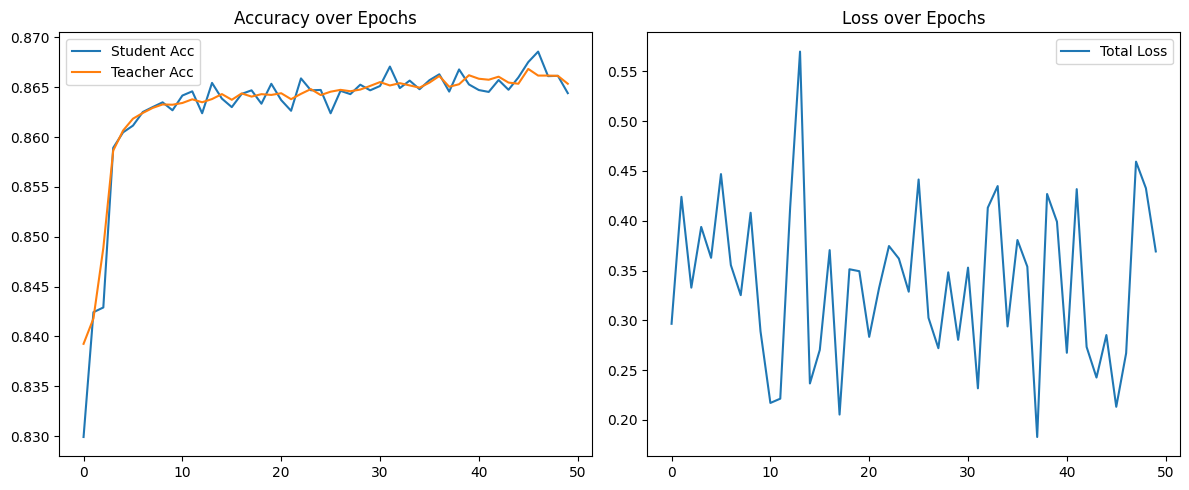

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# ================== CONFIG ==================
num_classes = len(np.unique(y_lab_supervised))
input_dim = X_lab_supervised.shape[1]
epochs = 50
batch_size = 512
ema_decay = 0.99
lambda_consistency = 0.5
confidence_threshold = 0.8
patience = 10

# ================== MODEL DEFINITIONS ==================
def build_mlp_model(input_dim, num_classes):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

student_model = build_mlp_model(input_dim, num_classes)
teacher_model = build_mlp_model(input_dim, num_classes)
teacher_model.set_weights(student_model.get_weights())

optimizer = optimizers.Adam(learning_rate=1e-3)
loss_fn = losses.SparseCategoricalCrossentropy()

# ================== TRAINING STEP ==================
@tf.function
def train_step(x_labeled, y_labeled, x_unlabeled):
    with tf.GradientTape() as tape:
        logits_labeled = student_model(x_labeled, training=True)
        supervised_loss = loss_fn(y_labeled, logits_labeled)

        student_preds = student_model(x_unlabeled, training=True)
        teacher_preds = teacher_model(x_unlabeled, training=False)

        teacher_conf = tf.reduce_max(teacher_preds, axis=1)
        mask = tf.where(teacher_conf > confidence_threshold)
        filtered_student = tf.gather(student_preds, mask[:, 0])
        filtered_teacher = tf.gather(teacher_preds, mask[:, 0])

        consistency_loss = tf.reduce_mean(tf.square(filtered_student - filtered_teacher))
        total_loss = supervised_loss + lambda_consistency * consistency_loss

    grads = tape.gradient(total_loss, student_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, student_model.trainable_variables))
    return supervised_loss, consistency_loss, total_loss

def update_teacher_weights(student_model, teacher_model, ema_decay):
    student_weights = student_model.get_weights()
    teacher_weights = teacher_model.get_weights()
    new_teacher_weights = [
        ema_decay * tw + (1 - ema_decay) * sw
        for sw, tw in zip(student_weights, teacher_weights)
    ]
    teacher_model.set_weights(new_teacher_weights)

# ================== PREPARE DATA ==================
X_lab_tf = tf.convert_to_tensor(X_lab_supervised, dtype=tf.float32)
y_lab_tf = tf.convert_to_tensor(y_lab_supervised, dtype=tf.int32)
X_unlab_tf = tf.convert_to_tensor(X_unlab, dtype=tf.float32)
X_test_tf = tf.convert_to_tensor(X_test, dtype=tf.float32)

train_accs, test_accs, losses_all = [], [], []
best_acc = 0
wait = 0

# ================== TRAIN ==================
for epoch in range(epochs):
    idxs = np.random.permutation(len(X_lab_supervised))
    num_batches = int(np.ceil(len(idxs) / batch_size))
    
    epoch_sup_loss, epoch_cons_loss = 0, 0

    for i in range(num_batches):
        batch_idx = idxs[i*batch_size:(i+1)*batch_size]
        x_batch = tf.gather(X_lab_tf, batch_idx)
        y_batch = tf.gather(y_lab_tf, batch_idx)

        unlab_batch_idx = np.random.choice(len(X_unlab_tf), size=len(batch_idx), replace=False)
        x_unlab_batch = tf.gather(X_unlab_tf, unlab_batch_idx)

        sup_loss, cons_loss, total_loss = train_step(x_batch, y_batch, x_unlab_batch)
        epoch_sup_loss += sup_loss.numpy()
        epoch_cons_loss += cons_loss.numpy()

        update_teacher_weights(student_model, teacher_model, ema_decay)

    y_pred_student = np.argmax(student_model.predict(X_test_tf, verbose=0), axis=1)
    y_pred_teacher = np.argmax(teacher_model.predict(X_test_tf, verbose=0), axis=1)
    acc_student = accuracy_score(y_test, y_pred_student)
    acc_teacher = accuracy_score(y_test, y_pred_teacher)

    train_accs.append(acc_student)
    test_accs.append(acc_teacher)
    losses_all.append(total_loss.numpy())

    print(f"[Epoch {epoch+1}/{epochs}] Sup Loss: {epoch_sup_loss:.3f}, Cons Loss: {epoch_cons_loss:.3f} | Student Acc: {acc_student:.4f} | Teacher Acc: {acc_teacher:.4f}")

    if acc_teacher > best_acc:
        best_acc = acc_teacher
        wait = 0
        teacher_model.save('best_mean_teacher_adaptive.h5')
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping.")
            break

# ================== EVALUATION ==================
print("\nBest Teacher Model Accuracy:", best_acc)
best_model = tf.keras.models.load_model('best_mean_teacher_adaptive.h5')
y_final = np.argmax(best_model.predict(X_test_tf, verbose=0), axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_final))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_final))

# ================== PLOTTING ==================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_accs, label='Student Acc')
plt.plot(test_accs, label='Teacher Acc')
plt.legend(); plt.title("Accuracy over Epochs")

plt.subplot(1,2,2)
plt.plot(losses_all, label='Total Loss')
plt.legend(); plt.title("Loss over Epochs")

plt.tight_layout(); plt.show()
